In [1]:
import json
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

In [2]:
teamID = 6990441
lastGameweek = 8

In [3]:
gameweekData = {}
for i in range(1, lastGameweek + 1):
    base = "https://fantasy.premierleague.com/api/entry/" + str(teamID) + "/event/" + str(i) + "/picks/"
    page = urllib.request.urlopen(base)
    data = {"GW" + str(i) : json.load(page)}
    gameweekData.update(data)

In [4]:
base = "https://fantasy.premierleague.com/api/entry/" + str(teamID) + "/"
page = urllib.request.urlopen(base)
dataTeamInfo = json.load(page)

In [5]:
base = "https://fantasy.premierleague.com/api/bootstrap-static/" 
page = urllib.request.urlopen(base)
dataGeneral = json.load(page)
events = dataGeneral["events"]
elements = dataGeneral["elements"]

In [6]:
def getPlayerPointsAtOneGW(playerID, gameweek):
    base = "https://fantasy.premierleague.com/api/element-summary/" + str(playerID) + "/"
    page = urllib.request.urlopen(base)
    datagw = json.load(page)
    gwPoints = 0
    for i in range(len(datagw["history"])): 
        if gameweek == datagw["history"][i]["round"]: 
            gwPoints = gwPoints + datagw["history"][i]["total_points"]  
    return gwPoints

In [7]:
def getPlayerName(playerID):
    i = 0
    while i < len(elements):
        if (elements[i]["id"] == playerID):
            return (elements[i]["first_name"] + " " + elements[i]["second_name"])
        i += 1
    return "ID not found"

In [8]:
positions = ["GK", "DEF", "MID", "ST"]
def getPlayerPosition(playerID):
    i = 0
    while i < len(elements):
        if (elements[i]["id"] == playerID):
                playersElementType = elements[i]["element_type"]
                playerPosition = positions[playersElementType - 1]
                return playerPosition
        i += 1
    return "ID not found"

In [9]:
def extract_basic_gameweek_data(gameweek_data, gw, events):
    """
    Extracts basic data like points, rank, team value, and transfers for a given gameweek.
    
    Parameters:
    - gameweek_data: Dictionary containing data for each gameweek.
    - gw: The specific gameweek (as an integer) to extract data from.
    - events: List of event data containing average and highest points for each gameweek.
    
    Returns:
    A dictionary containing the points, gameweek rank, overall rank, team value, number of transfers,
    transfer cost, average points, and highest points for the given gameweek.
    """
    entry_history = gameweek_data["GW" + str(gw)]["entry_history"]
    return {
        "points": entry_history["points"],
        "gameweekRank": entry_history["rank"],
        "overallRank": entry_history["overall_rank"],
        "teamValue": entry_history["value"],
        "transfers": entry_history["event_transfers"],
        "transfersCost": entry_history["event_transfers_cost"],
        "averagePoints": events[gw - 1]["average_entry_score"],
        "highestPoints": events[gw - 1]["highest_score"]
    }

def extract_captain_info(gameweek_data, gw):
    """
    Extracts the captain and captain points for a given gameweek.
    
    Parameters:
    - gameweek_data: Dictionary containing data for each gameweek.
    - gw: The specific gameweek (as an integer) to extract captain info from.
    
    Returns:
    A tuple with the captain's name and their points for the given gameweek.
    If no captain is found, returns (None, 0).
    """
    for player_pick in gameweek_data["GW" + str(gw)]["picks"]:
        if player_pick["is_captain"]:
            captain_name = getPlayerName(player_pick["element"])
            captain_points = getPlayerPointsAtOneGW(player_pick["element"], gw)
            return captain_name, captain_points
    return None, 0

def extract_starting_team(gameweek_data, gw):
    """
    Extracts the starting team data (players, their positions, and points) for a given gameweek.
    
    Parameters:
    - gameweek_data: Dictionary containing data for each gameweek.
    - gw: The specific gameweek (as an integer) to extract starting team info from.
    
    Returns:
    A dictionary where each key is 'player{n}', representing a player's data (name, position, points).
    """
    starting_team = {}
    for n in range(15):  # Loop over the 15 players (including substitutes)
        player_data = {
            "name": getPlayerName(gameweek_data["GW" + str(gw)]["picks"][n]["element"]),
            "position": getPlayerPosition(gameweek_data["GW" + str(gw)]["picks"][n]["element"]),
            "points": getPlayerPointsAtOneGW(gameweek_data["GW" + str(gw)]["picks"][n]["element"], gw)
        }
        starting_team[f"player{n}"] = player_data
    return starting_team

def calculate_points_per_line(starting_team):
    """
    Calculates the total points for each position line (GK, DEF, MID, ST) from the starting team.
    
    Parameters:
    - starting_team: Dictionary containing the starting team data for a gameweek.
    
    Returns:
    A dictionary with the total points for each position (GK, DEF, MID, ST).
    """
    points_per_line = {"GK": 0, "DEF": 0, "MID": 0, "ST": 0}
    for player in range(11):  # Only considering the first 11 players (the starting lineup)
        position = starting_team[f"player{player}"]["position"]
        points = starting_team[f"player{player}"]["points"]
        if position in points_per_line:
            points_per_line[position] += points
    return points_per_line

def update_season_points(points_per_line, total_points_per_line_season):
    """
    Updates the total season points for each position line by adding the points from the current gameweek.
    
    Parameters:
    - points_per_line: Dictionary containing the points per line for the current gameweek.
    - total_points_per_line_season: Dictionary storing the cumulative season points for each line.
    """
    for position in total_points_per_line_season:
        total_points_per_line_season[position] += points_per_line[position]

def process_gameweek_data(last_gameweek, gameweek_data, events):
    """
    Processes all gameweek data and aggregates relevant information such as points, ranks, team value, 
    transfers, captain information, starting team, and points per position for each gameweek.
    
    Parameters:
    - lastGameweek: The total number of gameweeks to process.
    - gameweek_data: Dictionary containing data for each gameweek.
    - events: List of event data containing average and highest points for each gameweek.
    
    Returns:
    A dictionary containing aggregated information for each gameweek:
    - points, gameweekRank, overallRank, teamValue, transfers, transfersCost, averagePoints, highestPoints
    - captain, captainPoints, startingTeam, totalPointsPerLine, totalPointsPerLineSeason
    """
    points = []
    gameweekRank = []
    overallRank = []
    teamValue = []
    transfers = []
    transfersCost = []
    averagePoints = []
    highestPoints = []
    captain = []
    captainPoints = []
    startingTeam = {}
    totalPointsPerLine = {}
    totalPointsPerLineSeason = {"GK": 0, "DEF": 0, "MID": 0, "ST": 0}

    for gw in range(1, lastGameweek + 1):
        # Extract basic data for the current gameweek
        gw_data = extract_basic_gameweek_data(gameweek_data, gw, events)
        points.append(gw_data["points"])
        gameweekRank.append(gw_data["gameweekRank"])
        overallRank.append(gw_data["overallRank"])
        teamValue.append(gw_data["teamValue"])
        transfers.append(gw_data["transfers"])
        transfersCost.append(gw_data["transfersCost"])
        averagePoints.append(gw_data["averagePoints"])
        highestPoints.append(gw_data["highestPoints"])

        # Extract captain information for the current gameweek
        captain_name, captain_points = extract_captain_info(gameweek_data, gw)
        captain.append(captain_name)
        captainPoints.append(captain_points)

        # Extract the starting team for the current gameweek
        starting_team = extract_starting_team(gameweek_data, gw)
        startingTeam[f"GW{gw}"] = starting_team

        # Calculate points per line (GK, DEF, MID, ST) for the current gameweek
        points_per_line = calculate_points_per_line(starting_team)
        totalPointsPerLine[f"GW{gw}"] = points_per_line

        # Update the season totals for points per line
        update_season_points(points_per_line, totalPointsPerLineSeason)

        print(f"GW{gw} : Done.")

    # Return the aggregated data
    return {
        "points": points,
        "gameweekRank": gameweekRank,
        "overallRank": overallRank,
        "teamValue": teamValue,
        "transfers": transfers,
        "transfersCost": transfersCost,
        "averagePoints": averagePoints,
        "highestPoints": highestPoints,
        "captain": captain,
        "captainPoints": captainPoints,
        "startingTeam": startingTeam,
        "totalPointsPerLine": totalPointsPerLine,
        "totalPointsPerLineSeason": totalPointsPerLineSeason
    }

# Process all gameweek data and store the summary in gameweek_summary
gameweek_summary = process_gameweek_data(lastGameweek, gameweekData, events)

GW1 : Done.
GW2 : Done.
GW3 : Done.
GW4 : Done.
GW5 : Done.
GW6 : Done.
GW7 : Done.
GW8 : Done.


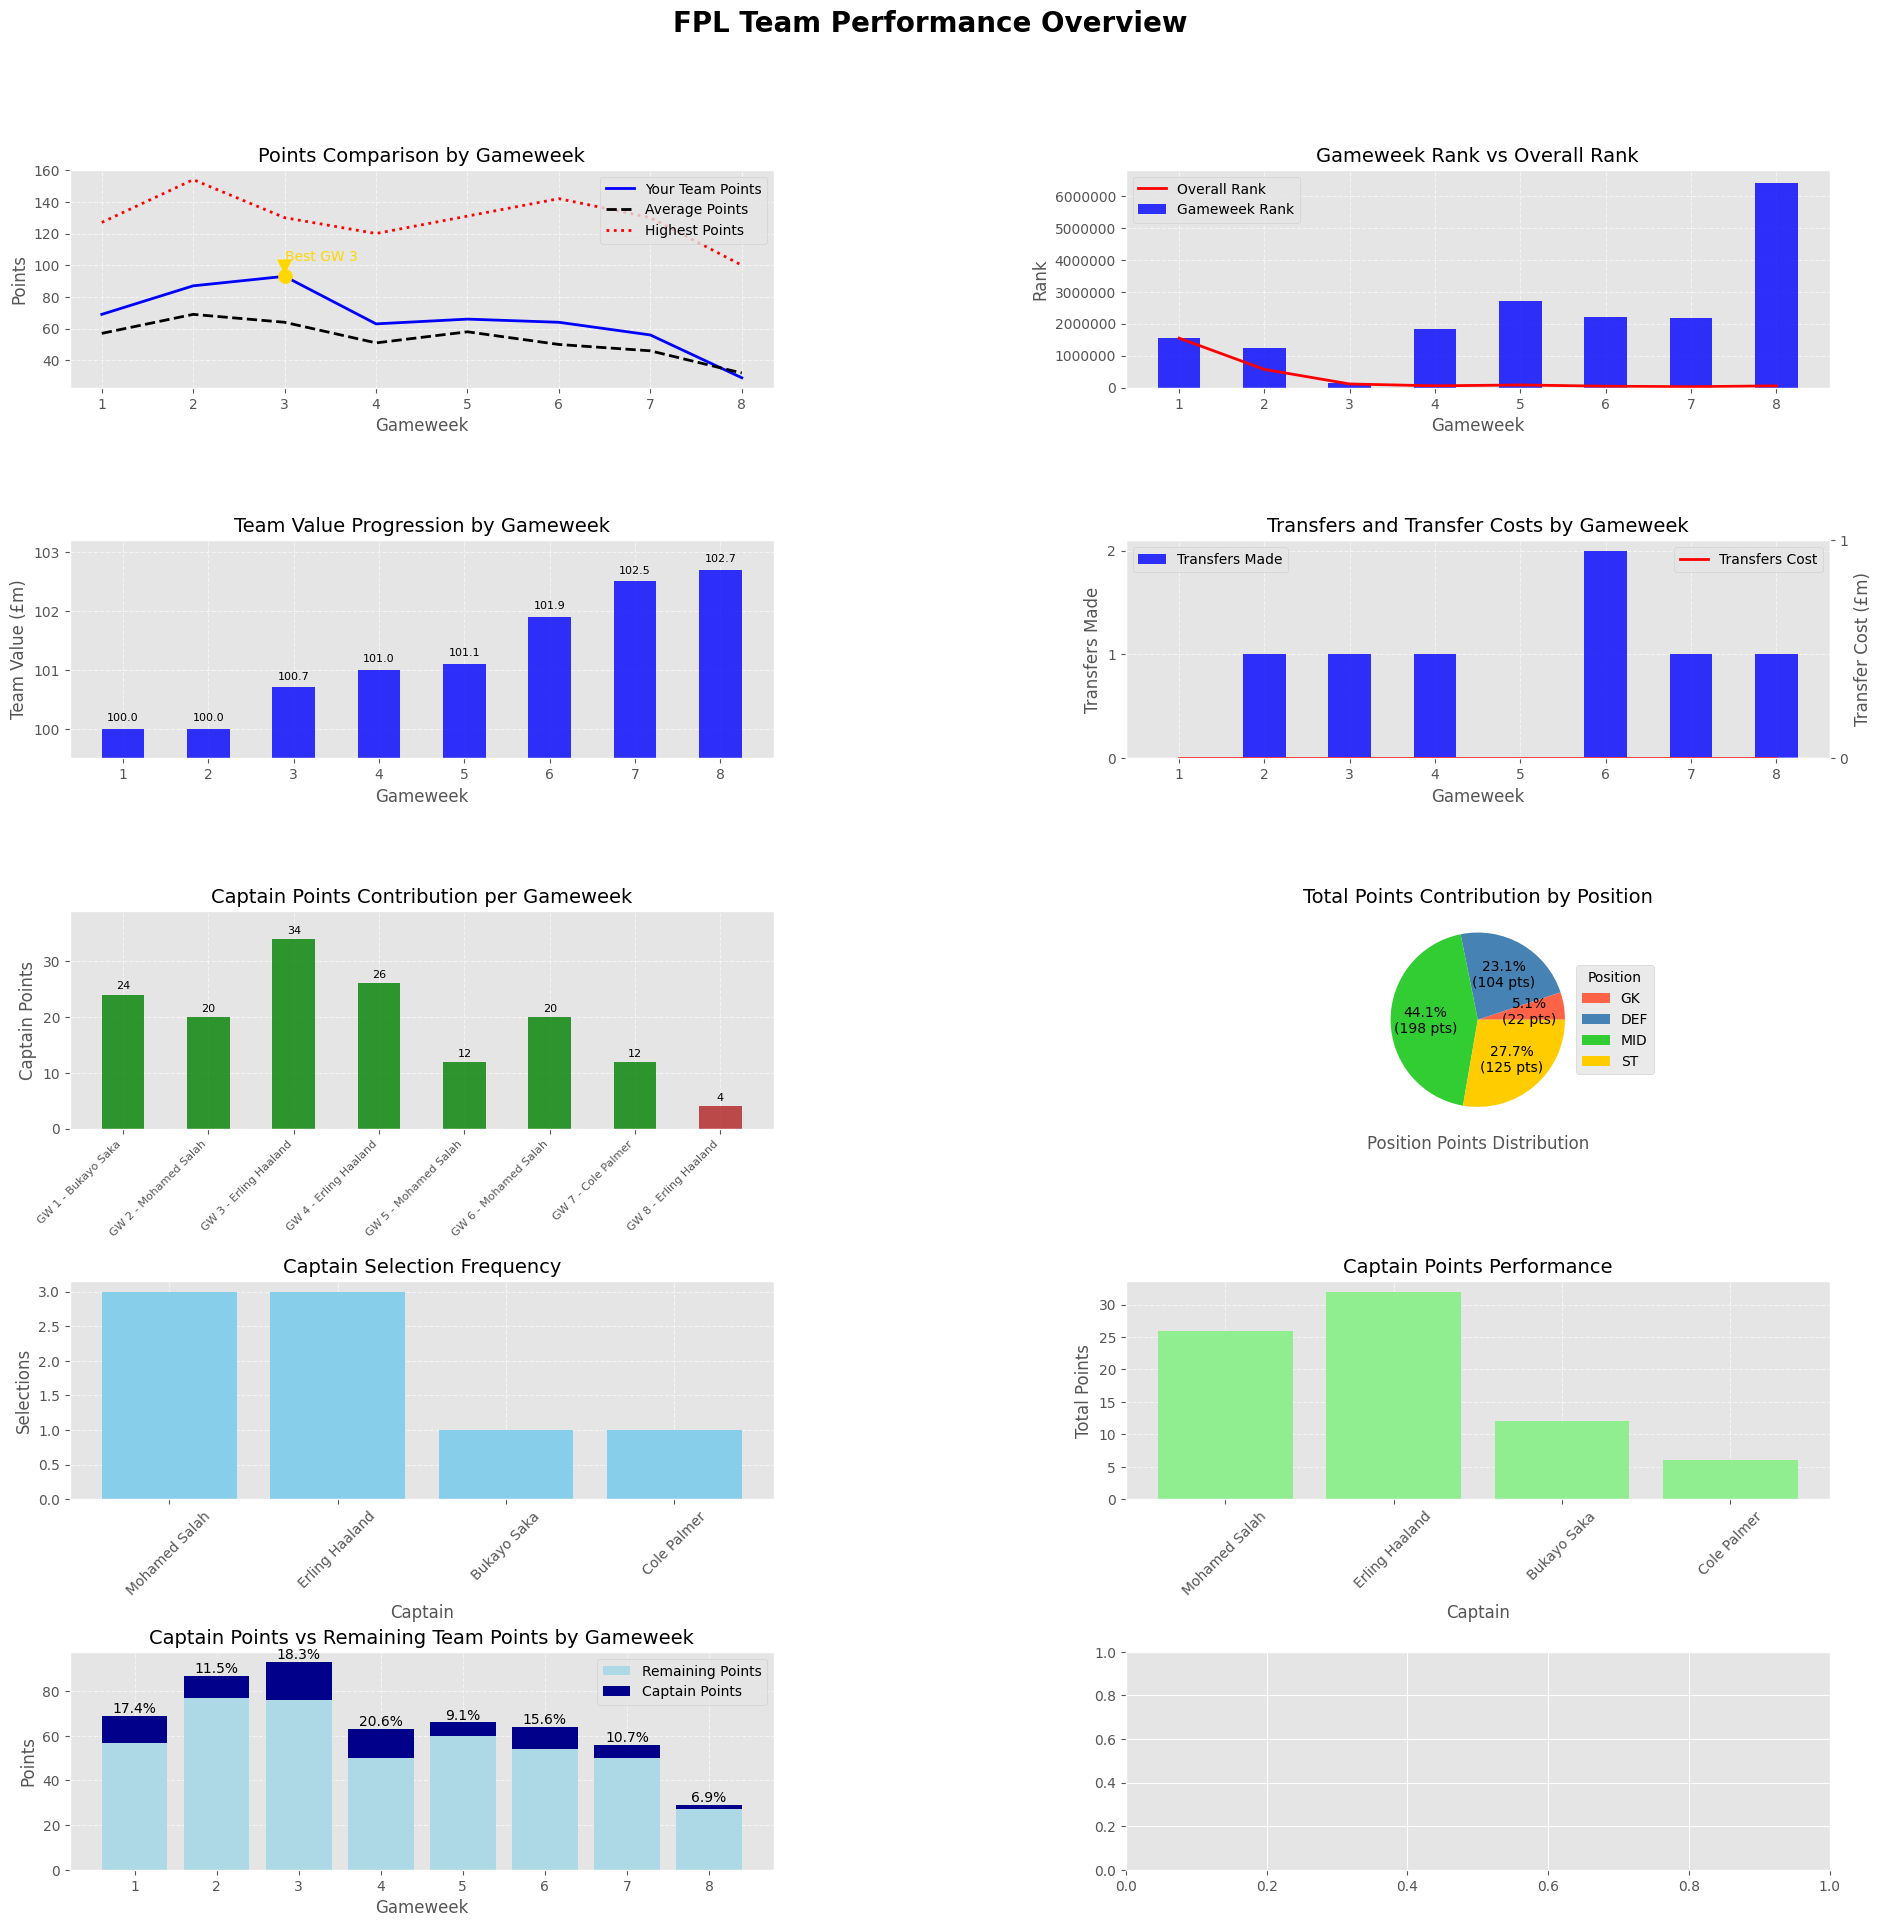

In [10]:
# Unpack data from gameweek_summary for plotting
points = gameweek_summary["points"]
gameweekRank = gameweek_summary["gameweekRank"]
overallRank = gameweek_summary["overallRank"]
teamValue = gameweek_summary["teamValue"]
transfers = gameweek_summary["transfers"]
transfersCost = gameweek_summary["transfersCost"]
averagePoints = gameweek_summary["averagePoints"]
highestPoints = gameweek_summary["highestPoints"]
captain = gameweek_summary["captain"]
captainPoints = gameweek_summary["captainPoints"]
totalPointsPerLineSeason = gameweek_summary["totalPointsPerLineSeason"]

# Set the gameweek range
gameweek = np.arange(1, lastGameweek + 1)

# Calculate remaining points (team points minus captain points)
remaining_points = [points[i] - captainPoints[i] for i in range(len(points))]

# Set plot aesthetics
plt.style.use('ggplot')
fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # Use `axes` to handle multiple subplots
fig.suptitle("FPL Team Performance Overview", fontsize=20, fontweight='bold')
fig.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.9, wspace=0.5, hspace=0.7)

# Assign subplots
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = axes.flatten()  # Flatten for easy access to all 10 subplots

### Team points comparison
ax1.plot(gameweek, points, color='b', label='Your Team Points', linewidth=2)
ax1.plot(gameweek, averagePoints, color='black', label='Average Points', linestyle='--', linewidth=2)
ax1.plot(gameweek, highestPoints, color='r', label='Highest Points', linestyle=':', linewidth=2)
ax1.set_xlabel('Gameweek', fontsize=12)
ax1.set_ylabel('Points', fontsize=12)
ax1.set_title('Points Comparison by Gameweek', fontsize=14)
ax1.legend(loc='best', frameon=True, prop={'size':10})
ax1.grid(True, linestyle='--', alpha=0.6)

### Highlight best gameweek
best_gw = np.argmax(points) + 1
best_gw_points = max(points)

ax1.scatter(best_gw, best_gw_points, color='gold', s=100, label='Best Gameweek', zorder=5)
ax1.annotate(f'Best GW {best_gw}', xy=(best_gw, best_gw_points), xytext=(best_gw, best_gw_points+10),
             arrowprops=dict(facecolor='gold', shrink=0.05), fontsize=10, color='gold')

### Gameweek rank vs overall rank
gameweekRank = np.array(gameweekRank)
ax2.bar(gameweek, gameweekRank, color='b', label='Gameweek Rank', width=0.5, alpha=0.8)
ax2.plot(gameweek, overallRank, color='r', label='Overall Rank', linewidth=2)
ax2.set_ylim(ymin=0)
ax2.set_ylim(ymax=max(gameweekRank + 400000))
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_xlabel('Gameweek', fontsize=12)
ax2.set_ylabel('Rank', fontsize=12)
ax2.set_title('Gameweek Rank vs Overall Rank', fontsize=14)
ax2.legend(loc='best', frameon=True, prop={'size':10})
ax2.grid(True, linestyle='--', alpha=0.6)

### Team value over time
team_value = list(map(lambda x: x / 10, teamValue))
ax3.bar(gameweek, team_value, width=0.5, color='b', alpha=0.8)
ax3.set_ylim(ymin=min(team_value) - 0.5, ymax=max(team_value) + 0.5)
ax3.set_xlabel('Gameweek', fontsize=12)
ax3.set_ylabel('Team Value (£m)', fontsize=12)
ax3.set_title('Team Value Progression by Gameweek', fontsize=14)
ax3.grid(True, linestyle='--', alpha=0.6)

# Adding labels on bars
rects = ax3.patches
for rect, label in zip(rects, team_value):
    height = rect.get_height()
    ax3.text(rect.get_x() + rect.get_width() / 2, height + 0.1, f'{label:.1f}', ha='center', va='bottom', size=8)

### Transfers and transfer costs
ax44 = ax4.twinx()
ax4.bar(gameweek, transfers, color='b', label='Transfers Made', width=0.5, alpha=0.8)
ax44.plot(gameweek, transfersCost, color='r', label='Transfers Cost', linewidth=2)
ax4.set_xlabel('Gameweek', fontsize=12)
ax4.set_ylabel('Transfers Made', fontsize=12)
ax44.set_ylabel('Transfer Cost (£m)', fontsize=12)
ax4.set_title('Transfers and Transfer Costs by Gameweek', fontsize=14)
ax4.legend(loc=2, frameon=True, prop={'size':10})
ax44.legend(loc=1, frameon=True, prop={'size':10})
ax44.set_ylim(ymin=0, ymax=max(transfersCost) + 1)
ax4.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax44.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax4.grid(True, linestyle='--', alpha=0.6)

### Captain performance by gameweek
captainPoints = np.array(captainPoints)
captainDisplay = [f"GW {n + 1} - {captain[n]}" for n in range(lastGameweek)]
mask1 = captainPoints > 3
mask2 = captainPoints <= 3
ax5.bar(gameweek[mask1], captainPoints[mask1] * 2, width=0.5, color='green', alpha=0.8)
ax5.bar(gameweek[mask2], captainPoints[mask2] * 2, width=0.5, color='firebrick', alpha=0.8)
ax5.set_ylim(ymin=0, ymax=max(captainPoints * 2) + 5)
ax5.set_xticks(gameweek)
ax5.set_xticklabels(captainDisplay, rotation=45, ha="right", size=8)
ax5.set_ylabel('Captain Points', fontsize=12)
ax5.set_title('Captain Points Contribution per Gameweek', fontsize=14)
ax5.grid(True, linestyle='--', alpha=0.6)

# Adding text labels on bars
rects = ax5.patches
for rect in rects:
    height = rect.get_height()
    ax5.text(rect.get_x() + rect.get_width() / 2, height + 0.6, height, ha='center', va='bottom', size=8)

### Points distribution by position
positions = list(totalPointsPerLineSeason.keys())
pointsPos = list(totalPointsPerLineSeason.values())
colors = ['#ff6347',  
          '#4682b4',  
          '#32cd32',  
          '#ffcc00']  

def func(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return "{:.1f}%\n({:d} pts)".format(pct, absolute)

wedges, texts, autotexts = ax6.pie(pointsPos, autopct=lambda pct: func(pct, pointsPos),
                                   textprops=dict(color="k"), colors=colors)

ax6.legend(wedges, positions, title="Position", loc="center left", bbox_to_anchor=(0.92, 0, 0.5, 1))
ax6.set_xlabel("Position Points Distribution", fontsize=12)
ax6.set_title('Total Points Contribution by Position', fontsize=14)

### Captain selection and effectiveness
captain_counts = pd.Series(captain).value_counts()  # Count how often each captain was selected
captain_performance = {cap: np.sum([captainPoints[i] for i in range(len(captain)) if captain[i] == cap])
                       for cap in captain_counts.index}  # Total points earned by each captain


ax7.bar(captain_counts.index, captain_counts.values, color='skyblue', label='Captain Selections')
ax7.set_title('Captain Selection Frequency', fontsize=14)
ax7.set_xlabel('Captain', fontsize=12)
ax7.set_ylabel('Selections', fontsize=12)
ax7.grid(True, linestyle='--', alpha=0.6)
ax7.tick_params(axis='x', rotation=45)

# Captain points performance
ax8.bar(captain_performance.keys(), captain_performance.values(), color='lightgreen', label='Total Captain Points')
ax8.set_title('Captain Points Performance', fontsize=14)
ax8.set_xlabel('Captain', fontsize=12)
ax8.set_ylabel('Total Points', fontsize=12)
ax8.grid(True, linestyle='--', alpha=0.6)
ax8.tick_params(axis='x', rotation=45)

# Calculate total points for each gameweek (remaining + captain points)
total_points = np.array(remaining_points) + np.array(captainPoints)

# Create stacked bar plot
ax9.bar(gameweek, remaining_points, label='Remaining Points', color='lightblue')
ax9.bar(gameweek, captainPoints, bottom=remaining_points, label='Captain Points', color='darkblue')

for i, gw in enumerate(gameweek):
    if total_points[i] > 0:
        percentage = (captainPoints[i] / total_points[i]) * 100
        ax9.text(gw, total_points[i], f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, color='black')


ax9.set_xlabel('Gameweek', fontsize=12)
ax9.set_ylabel('Points', fontsize=12)
ax9.set_title('Captain Points vs Remaining Team Points by Gameweek', fontsize=14)
ax9.legend(loc='best', frameon=True)
ax9.grid(True, linestyle='--', alpha=0.6)

plt.show()